In [ ]:
%pip install scvi-tools

In [ ]:
import joblib
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import pathlib
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42)
np.random.seed(38)
random.seed(38)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42

from orion.utils.vae_functions import make_predictions
from orion.utils.reporting import plot_roc, plot_stratified_sensitivities

# Functions for making predictions

In [ ]:
def predict_orion(
        pytorch_path: str,
        joblib_path: str,
        meta_df: pd.DataFrame,
        mir_df: pd.DataFrame,
        onc_df: pd.DataFrame,
        mini_batch: int = 512):
    """
    Generates Orion model scores

    Parameters
    ----------
    pytorch_path : str
        Path to the PyTorch model
    joblib_path : str
        Path to the joblib model
    meta_df : pd.DataFrame
        Metadata DataFrame
    mir_df : pd.DataFrame
        miRNA DataFrame
    onc_df : pd.DataFrame
        oncRNA DataFrame
    
    Returns
    -------
    pd.DataFrame
        Performance DataFrame
    """
    assert pytorch_path.endswith(".pt")
    assert joblib_path.endswith(".joblib")
    model_dict = joblib.load(joblib_path)
    perf_df, _, _ = make_predictions(
        joblib_path, pytorch_path,
        meta_df,
        mir_df.loc[meta_df.index],
        onc_df.loc[meta_df.index],
        dict_params=model_dict["dict_params"],
        report_shap=False,
        mini_batch=mini_batch,
        label_column="label",
    )
    perf_df["score"] = perf_df["Cancer.Prob"]
    return perf_df


def merge_predictions(
        meta_df: pd.DataFrame,
        dict_performance_dfs: dict):
    """
    Merges predictions from multiple models

    Parameters
    ----------
    meta_df : pd.DataFrame
        Metadata DataFrame
    dict_performance_dfs : dict
        Dictionary of performance DataFrames
    
    Returns
    -------
    pd.DataFrame
        Merged performance DataFrame
    """
    perf_df = meta_df.copy()
    # initialize score array with zero values
    score_ar = np.zeros(
        (perf_df.shape[0], len(list(dict_performance_dfs.keys())))
    )
    # iterate throgh predictions and fill the score array
    for i, (_, perf_df_) in enumerate(dict_performance_dfs.items()):
        score_ar[:, i] = np.array(perf_df_.loc[perf_df.index, "score"])

    average_score = np.apply_along_axis(
        np.mean, axis=1, arr=score_ar
    )
    score_variance = np.apply_along_axis(
        np.var, axis=1, arr=score_ar
    )

    assert average_score.shape[0] == perf_df.shape[0], "Mismatch"
    perf_df["score"] = average_score
    perf_df["score.variance"] = score_variance
    return perf_df


def predict_orion(
        pytorch_path: str,
        joblib_path: str,
        meta_df: pd.DataFrame,
        mir_df: pd.DataFrame,
        onc_df: pd.DataFrame,
        mini_batch: int = 512):
    """
    Generates Orion model scores

    Parameters
    ----------
    pytorch_path : str
        Path to the PyTorch model
    joblib_path : str
        Path to the joblib model
    meta_df : pd.DataFrame
        Metadata DataFrame
    mir_df : pd.DataFrame
        miRNA DataFrame
    onc_df : pd.DataFrame
        oncRNA DataFrame
    
    Returns
    -------
    pd.DataFrame
        Performance DataFrame
    """
    assert pytorch_path.endswith(".pt")
    assert joblib_path.endswith(".joblib")
    model_dict = joblib.load(joblib_path)
    print(model_dict.keys())
    perf_df, _, _ = make_predictions(
        joblib_path, pytorch_path,
        meta_df,
        mir_df.loc[meta_df.index],
        onc_df.loc[meta_df.index],
        dict_params=model_dict["dict_params"],
        report_shap=False,
        mini_batch=mini_batch,
        label_column="label",
        batch_column="cohort"
    )
    return perf_df


def merge_predictions(
        meta_df: pd.DataFrame,
        dict_performance_dfs: dict):
    """
    Merges predictions from multiple models

    Parameters
    ----------
    meta_df : pd.DataFrame
        Metadata DataFrame
    dict_performance_dfs : dict
        Dictionary of performance DataFrames
    
    Returns
    -------
    pd.DataFrame
        Merged performance DataFrame
    """
    perf_df = meta_df.copy()
    # initialize score array with zero values
    score_ar = np.zeros(
        (perf_df.shape[0], len(list(dict_performance_dfs.keys())))
    )
    # iterate throgh predictions and fill the score array
    for i, (_, perf_df_) in enumerate(dict_performance_dfs.items()):
        score_ar[:, i] = np.array(perf_df_.loc[perf_df.index, "Cancer.Prob"])

    average_score = np.apply_along_axis(
        np.mean, axis=1, arr=score_ar
    )
    score_variance = np.apply_along_axis(
        np.var, axis=1, arr=score_ar
    )

    assert average_score.shape[0] == perf_df.shape[0], "Mismatch"
    perf_df["score"] = average_score
    perf_df["score.variance"] = score_variance
    return perf_df


def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Load data

In [ ]:
DATA_DIR = pathlib.Path(
    "data/v1.0.0"
)
META_PATH = DATA_DIR / "metadata.tsv.gz"
MIRNA_PATH = DATA_DIR / 'mirna_counts.tsv.gz'
ONCRNA_PATH = DATA_DIR / 'oncrna_counts.tsv.gz'

OUT_DIR = DATA_DIR / "results"
OUT_DIR.mkdir(exist_ok=True)

DICT_MODEL_DIRS = {
    "Orion": DATA_DIR / "orion",
}

In [ ]:
meta_df = pd.read_csv(META_PATH, sep="\t", index_col=0)
meta_df["label"] = meta_df["cohort"] == "CANC"
control_samples = meta_df.index[meta_df['cohort'] == "NORM"]
meta_df.loc[control_samples, "cancer_stage"] = "normal"
meta_df.loc[control_samples, "t_score"] = "normal"
onc_df = pd.read_csv(ONCRNA_PATH, sep="\t", index_col=0)
mir_df = pd.read_csv(MIRNA_PATH, sep="\t", index_col=0)
print(f"{meta_df.shape=:} {onc_df.shape=:} {mir_df.shape=:}")
meta_df.head()

meta_df.shape=(210, 7) onc_df.shape=(210, 14014) mir_df.shape=(210, 4694)


,patient_id,cohort,cancer_stage,t_score,num_mirna_reads,reads_dedup_mapped,label
sample_id,,,,,,,
EXAI_S_00002,EXAI_P_00001,CANC,II,T2,133355.0,7897683,True
EXAI_S_00035,EXAI_P_00002,CANC,II,T2,55885.0,7555406,True
EXAI_S_00041,EXAI_P_00003,CANC,I,T2,53653.0,7863741,True
EXAI_S_00090,EXAI_P_00004,CANC,I,T1,56964.0,9190268,True
EXAI_S_00143,EXAI_P_00005,NORM,normal,normal,26096.0,6125599,False


# Make predictions

In [ ]:
dict_performances = {}
for model_name, model_dir in DICT_MODEL_DIRS.items():
    out_path = OUT_DIR / f"{model_name}_performance.tsv.gz"
    if not os.path.exists(out_path):
        dict_model_perf_dfs = {}
        for model_folder in tqdm(next(os.walk(model_dir))[1], desc=f"Predicting with {model_name}"):
            joblib_paths = [
                model_dir / model_folder / each
                for each in os.listdir(model_dir / model_folder)
                if each.endswith(".joblib")
            ]
            assert len(joblib_paths) == 1, "More than one joblib file"
            param_paths = [
                model_dir / model_folder / each
                for each in os.listdir(model_dir / model_folder)
                if each.endswith(".pt")
            ]
            assert len(param_paths) == 1, "More than one param file"
            perf_df = predict_orion(
                str(param_paths[0]),
                str(joblib_paths[0]),
                meta_df, mir_df, onc_df,
            )
            dict_model_perf_dfs[model_folder] = perf_df
        perf_df = merge_predictions(
            meta_df, dict_model_perf_dfs
        )
        perf_df.to_csv(OUT_DIR / f"{model_name}_performance.tsv.gz", sep="\t", compression="gzip")
        dict_performances[model_name] = perf_df
    else:
        dict_performances[model_name] = pd.read_csv(out_path, sep="\t", index_col=0)


dict_performances.keys()

dict_keys(['Orion'])

# Plot performance

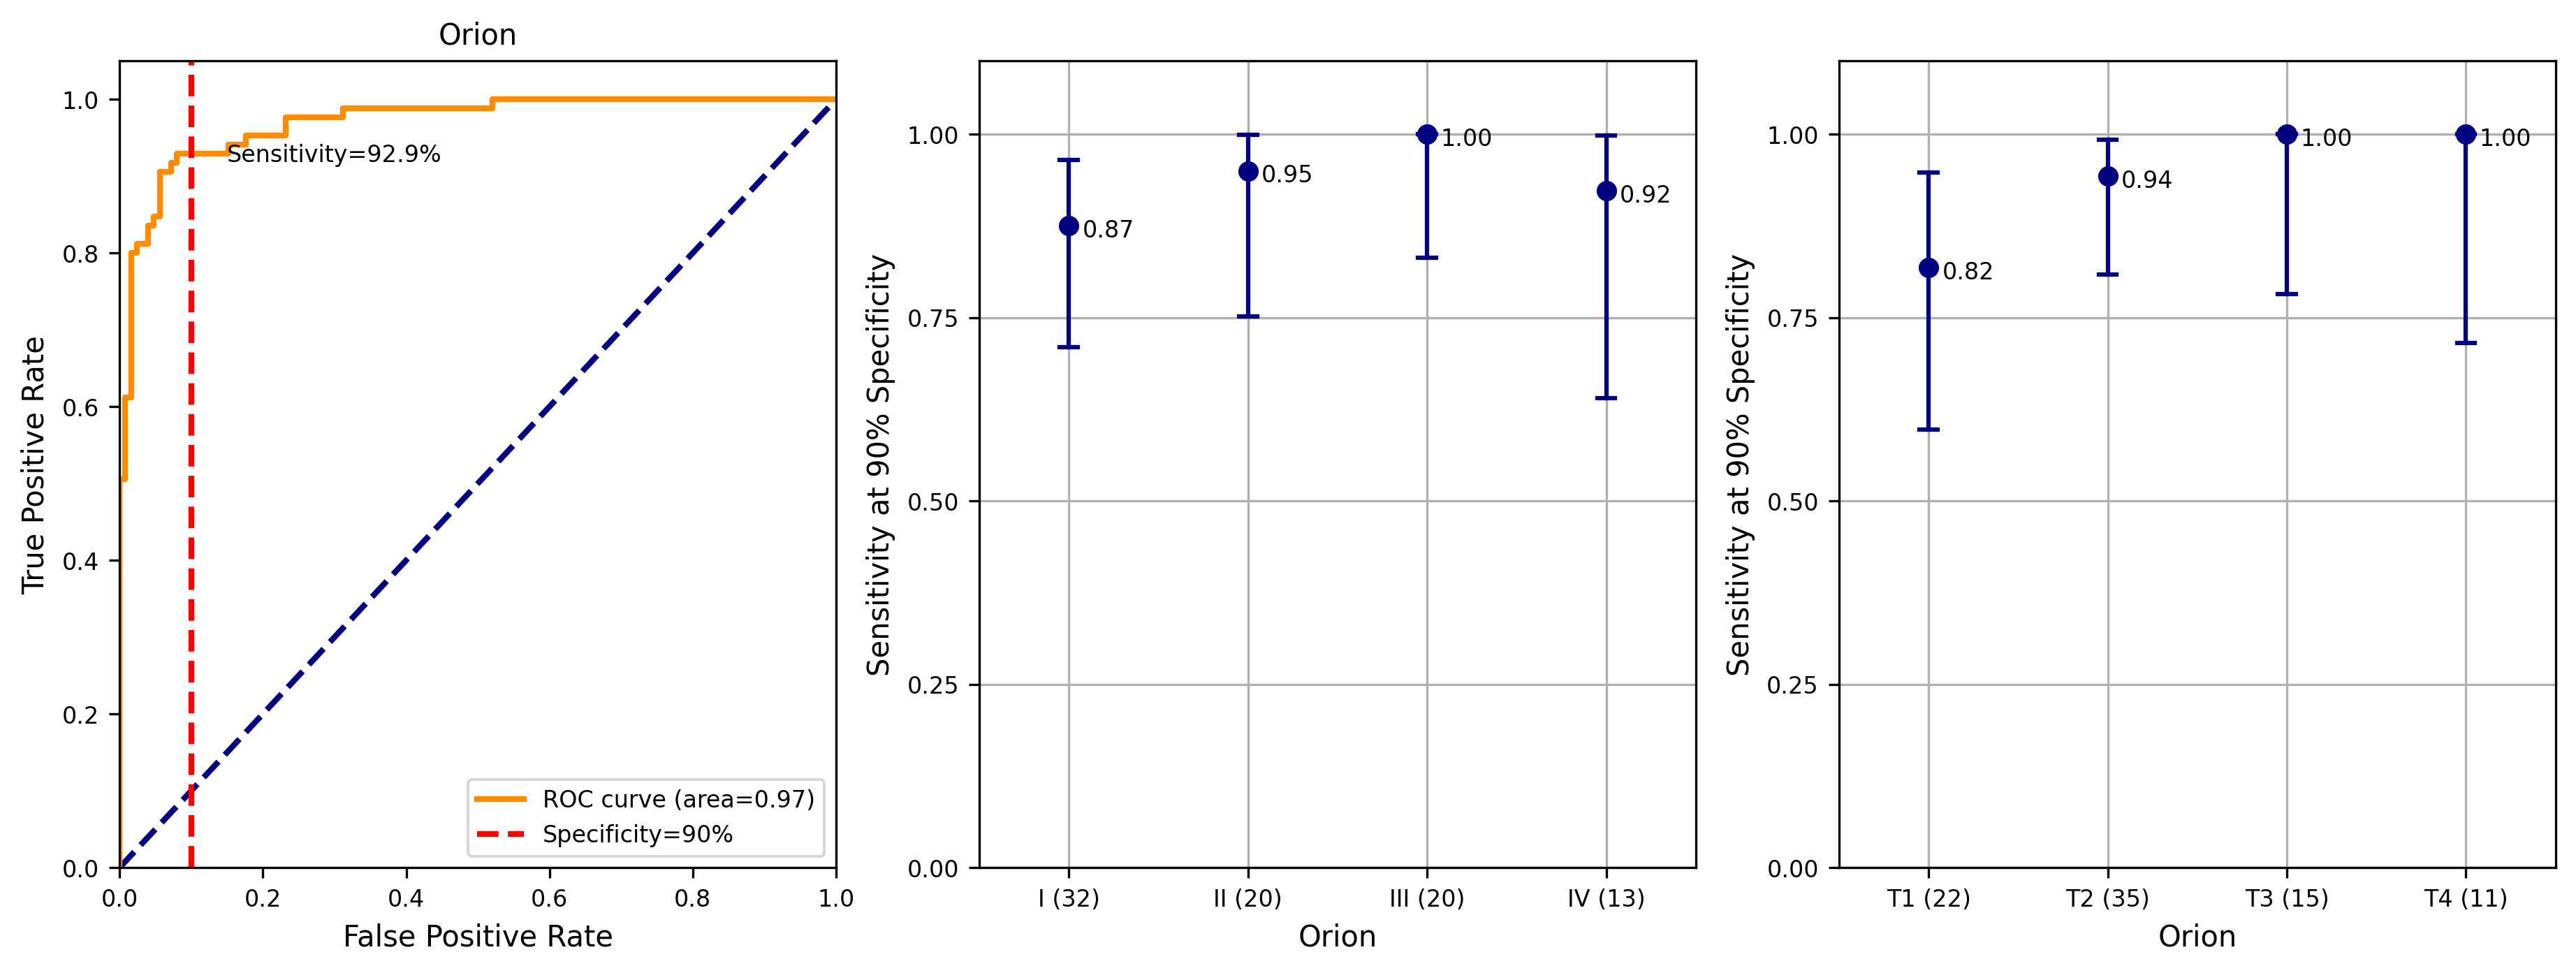

In [ ]:
for i, (model_name, perf_df) in enumerate(dict_performances.items()):
    fig, axs = plt.subplots(figsize=(15, 5), ncols=3, nrows=1, facecolor="white")
    perf_df["cancer_stage"] = meta_df.loc[perf_df.index, "cancer_stage"]
    perf_df["t_score"] = meta_df.loc[perf_df.index, "t_score"]
    plot_roc(perf_df, ax=axs[0], title=model_name, fpr=0.1)
    plot_stratified_sensitivities(
        perf_df, dict(zip(perf_df.index, perf_df["cancer_stage"])),
        ax=axs[1], xlabel=model_name, fpr=0.1)
    perf_df = perf_df[
        perf_df["t_score"].isin(["normal", "T1", "T2", "T3", "T4"])
    ]
    plot_stratified_sensitivities(
        perf_df, dict(zip(perf_df.index, perf_df["t_score"].map(str))),
        ax=axs[2], xlabel=model_name, fpr=0.1)